In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two sequences"""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def compute_distance_matrix(sequences):
    """Compute pairwise Hamming distance matrix"""
    n = len(sequences)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = hamming_distance(sequences[i], sequences[j])
            distances[i,j] = dist
            distances[j,i] = dist
    return distances

def knn_smooth(dist_mat: np.ndarray, n_neighbor: int) -> np.ndarray:
    """
    perform smooth to the distance matrix by sampling neighbours and take the mean
    Args:
        dist_mat: n x n matrix, each row/column is a point
        n_neighbor: number of neighbors to be sampled for each point
    Returns:
        smoothed distance matrix
    """
    n = len(dist_mat)
    neighbor_inds_mat = np.argpartition(dist_mat, n_neighbor, axis=1)[:, :n_neighbor]

    ret_mat = np.zeros_like(dist_mat, dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            tmp_sum = 0.0
            for ii in neighbor_inds_mat[i]:
                for jj in neighbor_inds_mat[j]:
                    tmp_sum += dist_mat[ii, jj]
            ret_mat[i, j] = tmp_sum / n_neighbor / n_neighbor
            ret_mat[j, i] = ret_mat[i, j]
    return ret_mat

def sigmoid(dist_mat: np.ndarray, max_val=16.0, change_point=10.0, scale_factor=3.0) -> np.ndarray:

    assert max_val > change_point > 0
    assert scale_factor > 0
    return max_val / (1 + np.exp(-scale_factor * (dist_mat - change_point)))

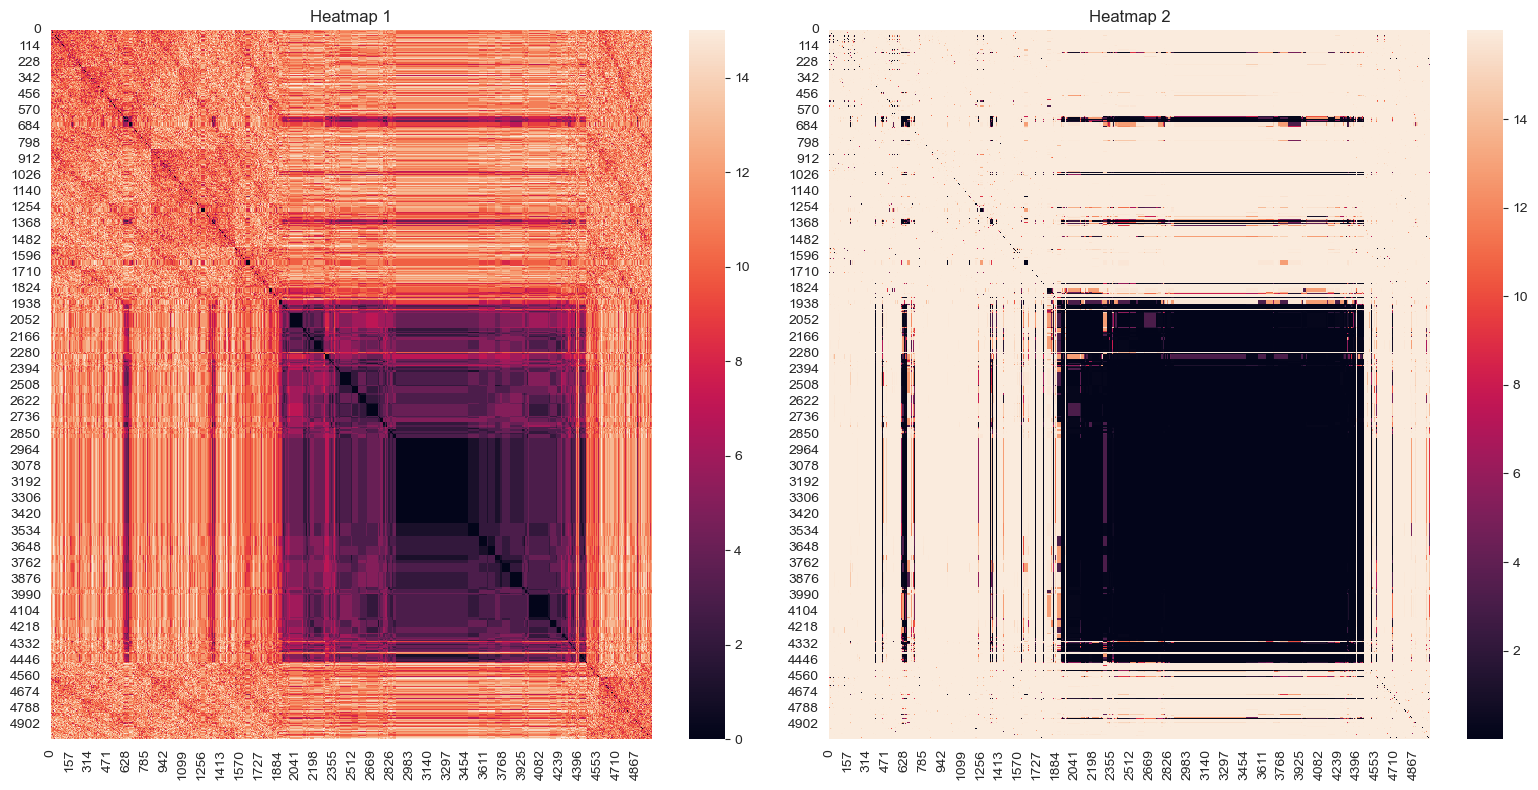

In [3]:
# %matplotlib inline

print("Warning: this step may take 10 minutes.")

kmers_df = pd.read_csv("sample_kmers.csv",header=None).values
kmers = kmers_df[:, 0].tolist()
labels_df = pd.read_csv("sample_labels.csv", header=None)
labels = labels_df.iloc[:, 0].tolist()

kmer_len = len(kmers[0])
mat1 = compute_distance_matrix(kmers)
mat1_smoothed = knn_smooth(mat1, 10)

mat2 = sigmoid(mat1_smoothed, 16.0,  change_point=kmer_len/2, scale_factor=0.2 * kmer_len - 0.2)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))


sns.heatmap(mat1, ax=axes[0])
axes[0].set_title("Heatmap 1")


sns.heatmap(mat2, ax=axes[1])
axes[1].set_title("Heatmap 2")

plt.tight_layout()

plt.savefig("fig1_b.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()   #

In [4]:
# %matplotlib inline

# 1. Read the CSV file and build the distance matrix


# label 1 represents the motif k-mers and label 2 represents the random k-mers
# convert to 0 and 1, respectively
label_numeric = np.array([label-1 for label in labels])

# confirm label 0 corresponds to motif kmers
lab = 0
inds = np.where(label_numeric == lab)[0]
np.random.shuffle(inds)
print("motif kmers:")
for i in range(10):
    print(kmers[inds[i]])

print()
# confirm lable 1 corresponds to random kmers
lab = 1
inds = np.where(label_numeric == lab)[0]
np.random.shuffle(inds)
print("random kmers:")
for i in range(10):
    print(kmers[inds[i]])

motif kmers:
GGGAATCCCCCCCAG
GGGGATTCCCCCGAA
GGGAATCCCCCCCAG
GGGAATTCCCCTTAC
GGGGATTCCCCTCGA
GGGAATTCCCCTAAC
GGGGATTCCCCCTTA
GGGAATTCCCCAAAA
GGTGATTCCCCCAAA
GGGAATTCCCCCAAC

random kmers:
GAATCCCCACCGGGA
CAAACATTGATCCAC
ACTAGCTGGAAACTT
GGAAACACCTTGCTC
GCACGGTAAATCACT
GCCCCATCTTTGTCC
CTAACAAATGCCATT
CGATATAACTACAAC
AAGGGCTAAATCATC
GTGAGTACACGAAAC


G:\anaconda3\envs\kmap_demo\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
G:\anaconda3\envs\kmap_demo\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
G:\anaconda3\envs\kmap_demo\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
G:\anaconda3\envs\kmap_demo\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP embedding shape: (5000, 2)


G:\anaconda3\envs\kmap_demo\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE embedding shape: (5000, 2)
[0 1]


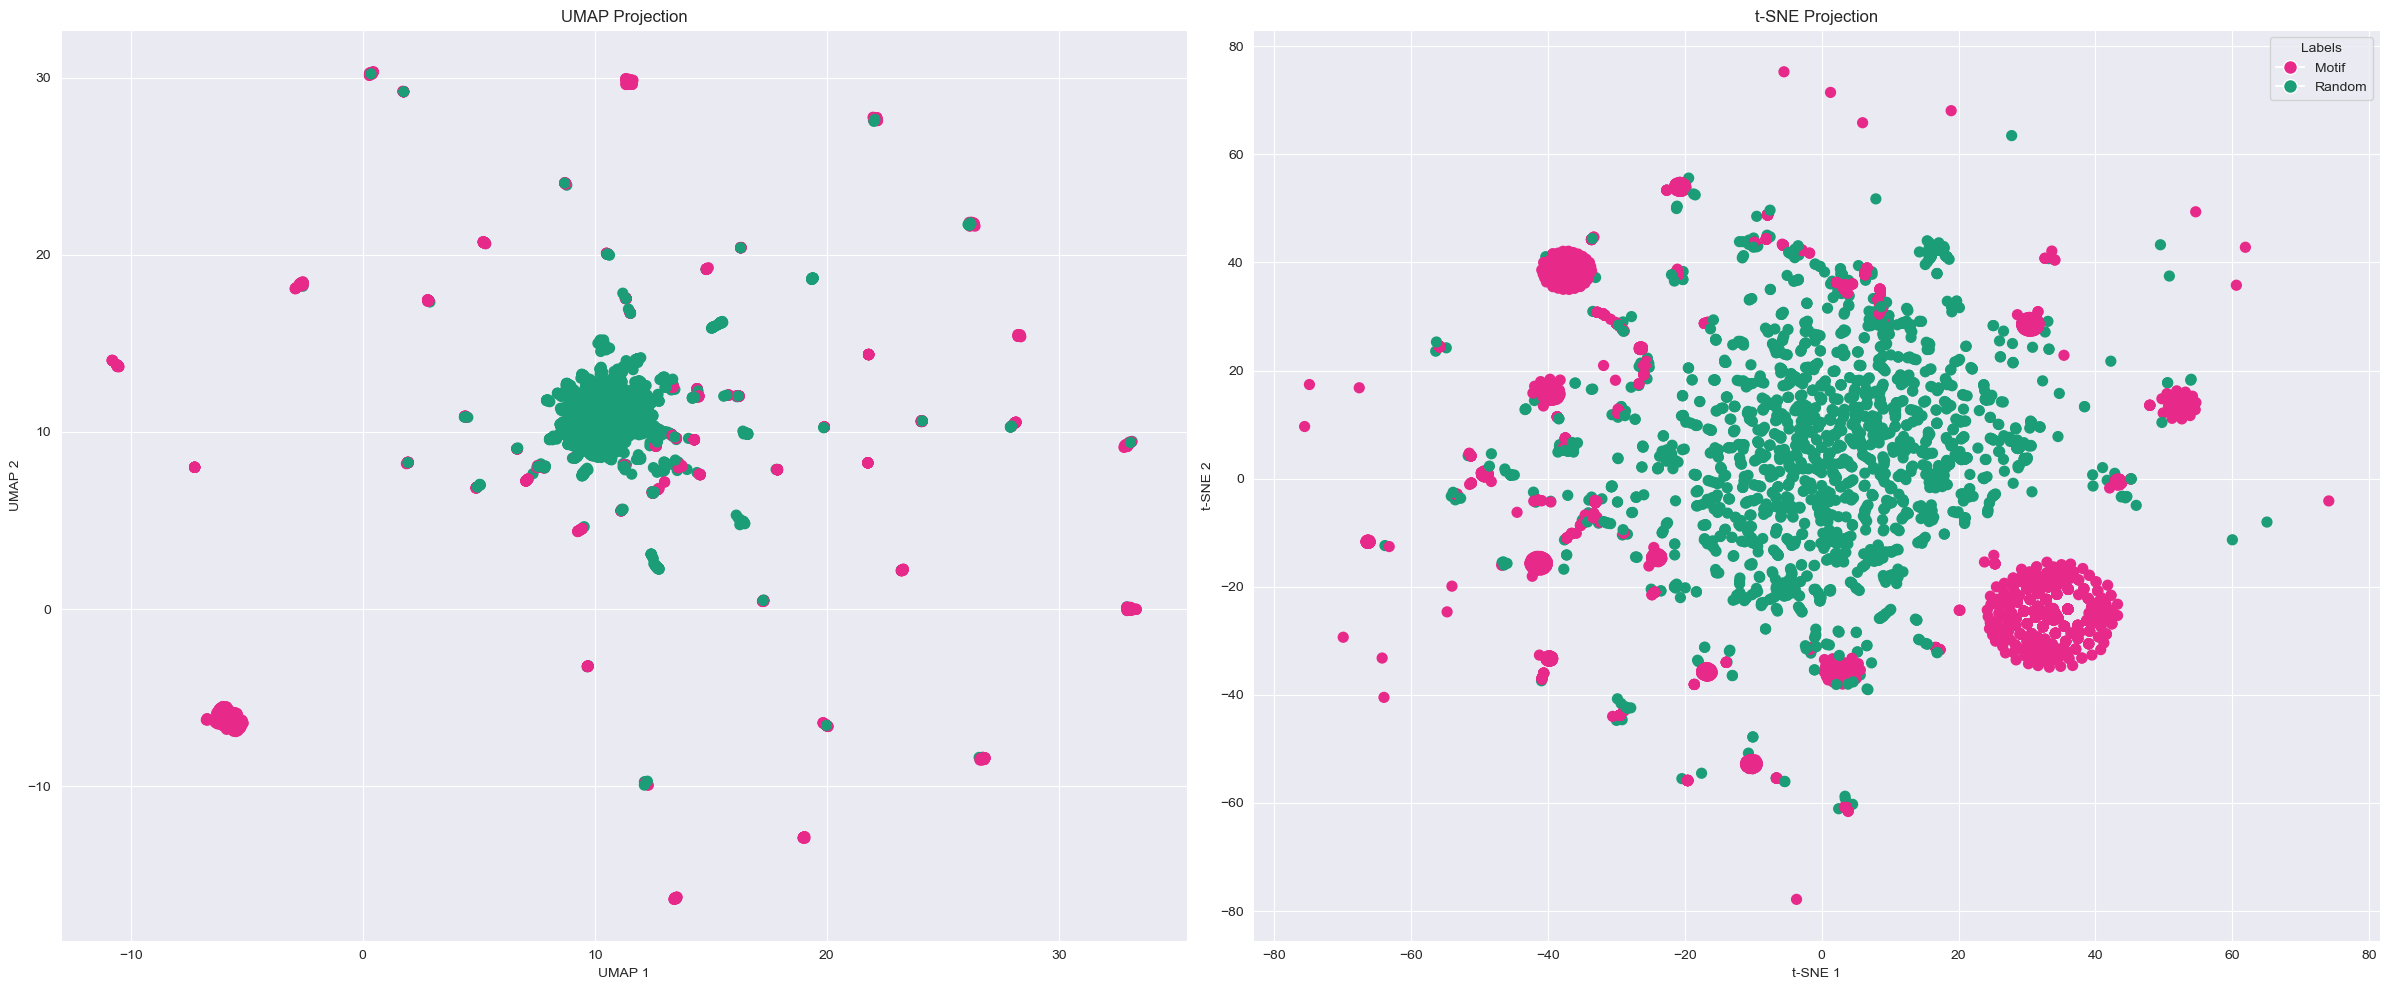

In [5]:


# 2. Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
umap_embedding = umap_reducer.fit_transform(mat2)
print("UMAP embedding shape:", umap_embedding.shape)

# 3. Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, metric='precomputed', random_state=42, perplexity=30, n_iter=1000, init="random")
tsne_embedding = tsne.fit_transform(mat2)
print("t-SNE embedding shape:", tsne_embedding.shape)

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(24, 10))


unique_labels = np.unique(label_numeric)
print(unique_labels)

label_mapping = {
    0: 'Motif',
    1: 'Random'
}

legend_labels = [label_mapping[label] for label in unique_labels]


palette = sns.color_palette("Dark2", 8)

color_mapping = {
    'Motif': palette[3],   #red
    'Random':  palette[0]   # green
}

colors = [color_mapping[label_mapping[label]] for label in label_numeric]

axes[0].scatter(umap_embedding[:, 0], umap_embedding[:, 1],
                s=50, c=colors)
axes[0].set_title('UMAP Projection')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].grid(True)


axes[1].scatter(tsne_embedding[:, 0], tsne_embedding[:, 1],
                s=50, c=colors)
axes[1].set_title('t-SNE Projection')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True)


legend_patches = []
for label in unique_labels:
    label_str = label_mapping[label]
    patch = plt.Line2D(
        [0], [0],
        marker='o', color='w', markersize=10,
        markerfacecolor=color_mapping[label_str]
    )
    legend_patches.append(patch)

axes[1].legend(legend_patches, legend_labels, title="Labels", loc='best')

plt.tight_layout()
plt.show()
plt.close()